### **Sales Analysis Report: PacRide**

#### **Objective**
PacRide, sebagai perusahaan yang bergerak dalam industri penjualan sepeda dan aksesorisnya, ingin meningkatkan performa penjualan pada produk-produk tertentu yang saat ini memiliki tingkat penjualan yang belum optimal. Fokus laporan ini adalah melakukan analisis mendalam terhadap subkategori produk yang telah ditentukan oleh tim manajemen sebagai prioritas untuk perbaikan. Melalui analisis data penjualan ini, kami bertujuan untuk memahami pola penjualan, mengidentifikasi area dengan permintaan tinggi, dan memberikan rekomendasi strategis untuk meningkatkan performa penjualan secara keseluruhan.

#### **Goals**
1. **Identifikasi Subkategori Terbaik**: Memahami subkategori mana yang memiliki kontribusi penjualan paling signifikan dan mana yang perlu diperbaiki, berdasarkan data historis penjualan.

2. **Analisis Wilayah Berbasis Penjualan**: Mengidentifikasi wilayah atau negara dengan performa penjualan tertinggi untuk masing-masing subkategori produk, sehingga dapat menjadi fokus pemasaran dan distribusi.

3. **Rekomendasi Strategis**: Memberikan rekomendasi berbasis data yang dapat mendukung strategi perusahaan dalam meningkatkan penjualan melalui:
   - Optimalisasi stok di wilayah dengan permintaan tinggi.
   - Penargetan kampanye promosi pada wilayah tertentu.
   - Penyusunan strategi harga berdasarkan wilayah dan permintaan.

4. **Peningkatan Efisiensi Operasional**: Mengurangi penumpukan stok pada produk yang kurang diminati di wilayah tertentu dan mengarahkan sumber daya ke area yang lebih menjanjikan.


In [21]:
# Import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession

# Optional: Set styles for better visualization
sns.set_theme(style="whitegrid")

In [22]:
# Membuat koneksi dengan Data Warehouse
jdbc_driver_path = r"C:\Users\ASUS\postgresql-42.7.4.jar"
jdbc_url = "jdbc:postgresql://localhost:5432/Pacride"
connection_properties = {"user":"postgres", "password":"Bismillah@30", "driver": "org.postgresql.Driver"}

spark = SparkSession.builder \
    .appName("Coba SQL") \
    .config("spark.jars", jdbc_driver_path)\
    .getOrCreate()

In [23]:
# Test Koneksi

import psycopg2

try:
    connection = psycopg2.connect(
        dbname="Pacride",
        user="postgres",
        password="Bismillah@30",
        host="localhost",
        port="5432",
        options="-c search_path=public"
    )
    print("Koneksi berhasil!")
except Exception:
    print(f"Error: Koneksi Gagal")


Koneksi berhasil!


### **Import Data**

In [24]:
# Query Data yang diperlukan

query = """SELECT 
    product.name AS product_name,
    subcategory,
    category,
    reseller.name AS reseller_name,
    region.name AS region_name,
    reseller.country,
    order_date,
    quantity,
    standard_cost,
    unit_price,
    sales,
    cost
FROM public.product
LEFT JOIN public.sales ON sales.product_key = product.product_key
LEFT JOIN public.reseller ON reseller.reseller_key = sales.reseller_key
LEFT JOIN public.region ON sales.sales_teritory_key = region.sales_teritory_key;
"""
df = pd.read_sql_query(query, connection)
df.head()


C:\Users\ASUS\AppData\Local\Temp\ipykernel_18076\3333447598.py:21: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, connection)


,product_name,subcategory,category,reseller_name,region_name,country,order_date,quantity,standard_cost,unit_price,sales,cost
0,"Long-Sleeve Logo Jersey, XL",Jerseys,Clothing,Resale Services,Southwest,United States,2017-08-25,2,$31.72,$28.84,$57.68,$63.45
1,"Mountain-100 Black, 48",Mountain Bikes,Bikes,Resale Services,Southwest,United States,2017-08-25,2,"$1,898.09","$2,024.99","$4,049.98","$3,796.19"
2,"Mountain-100 Black, 38",Mountain Bikes,Bikes,Resale Services,Southwest,United States,2017-08-25,2,"$1,898.09","$2,024.99","$4,049.98","$3,796.19"
3,"Long-Sleeve Logo Jersey, L",Jerseys,Clothing,Resale Services,Southwest,United States,2017-08-25,2,$31.72,$28.84,$57.68,$63.45
4,"HL Mountain Frame - Silver, 48",Mountain Frames,Components,Resale Services,Southwest,United States,2017-11-18,2,$706.81,$818.7,"$1,637.4","$1,413.62"


In [25]:
df.to_excel("pacride.xlsx")

### **Data Understanding**

In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57914 entries, 0 to 57913
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   product_name   57914 non-null  object
 1   subcategory    57914 non-null  object
 2   category       57914 non-null  object
 3   reseller_name  57851 non-null  object
 4   region_name    57851 non-null  object
 5   country        57851 non-null  object
 6   order_date     57851 non-null  object
 7   quantity       57851 non-null  object
 8   standard_cost  57914 non-null  object
 9   unit_price     57851 non-null  object
 10  sales          57851 non-null  object
 11  cost           57851 non-null  object
dtypes: object(12)
memory usage: 5.3+ MB


Insight: Type data kolom numerikal masih bertipe object, sehingga perlu diubah menjadi Integer untuk Quantity dan Float untuk data monetary

In [27]:
# Isi nilai kosong di kolom quantity dengan 0
df['quantity'] = df['quantity'].fillna(0).astype(int)

# Untuk kolom lainnya, isi nilai kosong dengan 0 sebelum konversi
df['standard_cost'] = df['standard_cost'].str.replace('$', '', regex=False).str.replace(',', '', regex=False).fillna(0)
df['unit_price'] = df['unit_price'].str.replace('$', '', regex=False).str.replace(',', '', regex=False).fillna(0)
df['sales'] = df['sales'].str.replace('$', '', regex=False).str.replace(',', '', regex=False).fillna(0)
df['cost'] = df['cost'].str.replace('$', '', regex=False).str.replace(',', '', regex=False).fillna(0)

# Konversi kolom lainnya ke float
df['standard_cost'] = pd.to_numeric(df['standard_cost'])
df['unit_price'] = pd.to_numeric(df['unit_price'])
df['sales'] = pd.to_numeric(df['sales'])
df['cost'] = pd.to_numeric(df['cost'])


In [45]:
df= df.fillna(0)

In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57914 entries, 0 to 57913
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   product_name   57914 non-null  object 
 1   subcategory    57914 non-null  object 
 2   category       57914 non-null  object 
 3   reseller_name  57851 non-null  object 
 4   region_name    57851 non-null  object 
 5   country        57851 non-null  object 
 6   order_date     57851 non-null  object 
 7   quantity       57914 non-null  int32  
 8   standard_cost  57914 non-null  float64
 9   unit_price     57914 non-null  float64
 10  sales          57914 non-null  float64
 11  cost           57914 non-null  float64
dtypes: float64(4), int32(1), object(7)
memory usage: 5.1+ MB


In [29]:
df.duplicated().sum()

4

Insight: Terdapat sebanyak 9554 data duplikat, sehingga perlu dilakukan cleansing untuk data duplikat. 

In [30]:
df.duplicated().sum()

4

In [31]:
df.rename(columns={'standard cost':'standard cost ($)', 'unit_price':'unit_price ($)', 'sales':'sales ($)', 'cost':'cost ($)'})

,product_name,subcategory,category,reseller_name,region_name,country,order_date,quantity,standard_cost,unit_price ($),sales ($),cost ($)
0,"Long-Sleeve Logo Jersey, XL",Jerseys,Clothing,Resale Services,Southwest,United States,2017-08-25,2,31.72,28.84,57.68,63.45
1,"Mountain-100 Black, 48",Mountain Bikes,Bikes,Resale Services,Southwest,United States,2017-08-25,2,1898.09,2024.99,4049.98,3796.19
2,"Mountain-100 Black, 38",Mountain Bikes,Bikes,Resale Services,Southwest,United States,2017-08-25,2,1898.09,2024.99,4049.98,3796.19
3,"Long-Sleeve Logo Jersey, L",Jerseys,Clothing,Resale Services,Southwest,United States,2017-08-25,2,31.72,28.84,57.68,63.45
4,"HL Mountain Frame - Silver, 48",Mountain Frames,Components,Resale Services,Southwest,United States,2017-11-18,2,706.81,818.70,1637.40,1413.62
...,...,...,...,...,...,...,...,...,...,...,...,...
57909,"HL Road Frame - Black, 58",Road Frames,Components,None,None,None,None,0,868.63,0.00,0.00,0.00
57910,ML Bottom Bracket,Bottom Brackets,Components,None,None,None,None,0,44.95,0.00,0.00,0.00
57911,"LL Road Frame - Black, 62",Road Frames,Components,None,None,None,None,0,170.14,0.00,0.00,0.00
57912,"LL Road Frame - Black, 48",Road Frames,Components,None,None,None,None,0,170.14,0.00,0.00,0.00


In [32]:
df_not_sold = df[df['quantity'] == 0 ].sort_values(['standard_cost', 'subcategory' ],ascending=False)
df_not_sold['standard_cost'].sum()

17305.87

In [33]:
df_need_sold = df_not_sold.groupby(['product_name','subcategory']).aggregate({'quantity':'count', 'standard_cost':'sum'}).sort_values(['subcategory'], ascending = [True]).reset_index()
df_need_sold

,product_name,subcategory,quantity,standard_cost
0,All-Purpose Bike Stand,Bike Stands,1,59.47
1,Road Bottle Cage,Bottles and Cages,1,3.36
2,Mountain Bottle Cage,Bottles and Cages,1,3.74
3,ML Bottom Bracket,Bottom Brackets,1,44.95
4,Fender Set - Mountain,Fenders,1,8.22
5,ML Fork,Forks,1,77.92
6,ML Road Handlebars,Handlebars,2,52.48
7,"Short-Sleeve Classic Jersey, M",Jerseys,1,41.57
8,"Long-Sleeve Logo Jersey, S",Jerseys,3,99.29
9,Taillights - Battery-Powered,Lights,1,5.77


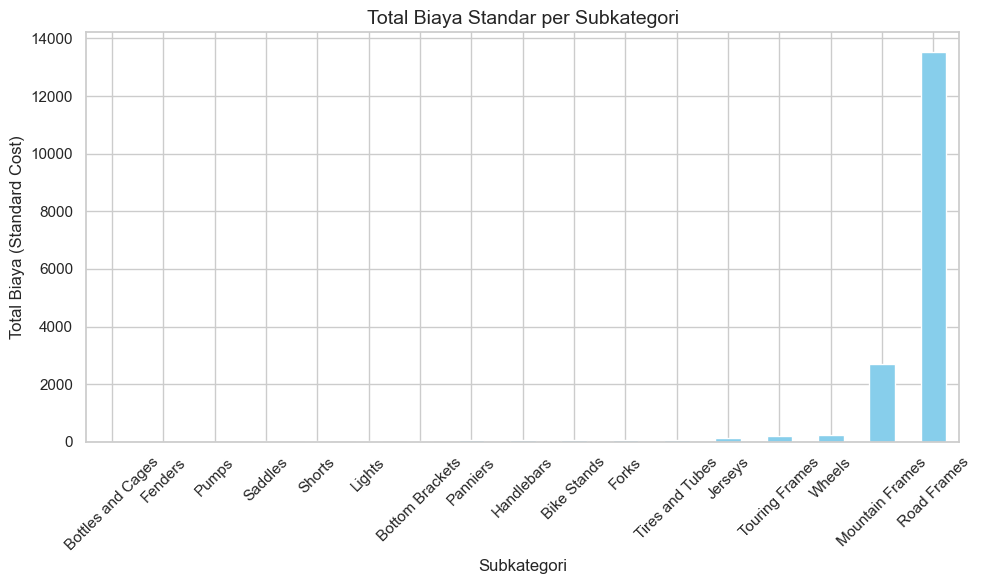

In [34]:
# 1. Bar Chart: Total biaya per subkategori
subcat_cost = df_not_sold.groupby('subcategory')['standard_cost'].sum().sort_values()
plt.figure(figsize=(10, 6))
subcat_cost.plot(kind='bar', color='skyblue')
plt.title('Total Biaya Standar per Subkategori', fontsize=14)
plt.ylabel('Total Biaya (Standard Cost)', fontsize=12)
plt.xlabel('Subkategori', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Insight: Berdasarkan data diatas diperoleh sebanyak 45 produk yang memiliki nilai sales 0 atau belum pernah dilakukan pembelian. Manajemen menginginkan kita untuk mencari tahu region mana saja yang berpotensi memiliki minat pembeli tinggi terhadap produk diatas

In [35]:
df_sold = df[df['quantity'] > 0 ].sort_values(['quantity', 'subcategory' ],ascending=False)
df_sold

,product_name,subcategory,category,reseller_name,region_name,country,order_date,quantity,standard_cost,unit_price,sales,cost
57664,"Full-Finger Gloves, L",Gloves,Clothing,Brakes and Gears,Northwest,United States,2019-05-20,44,15.67,17.10,752.40,689.52
57834,"Women's Mountain Shorts, L",Shorts,Clothing,Latest Sports Equipment,Northwest,United States,2020-04-05,41,26.18,31.50,1291.50,1073.23
57735,"Women's Mountain Shorts, S",Shorts,Clothing,Brakes and Gears,Northwest,United States,2019-08-18,40,26.18,35.00,1400.00,1047.05
57806,"Women's Mountain Shorts, L",Shorts,Clothing,Field Trip Store,Central,United States,2019-11-29,40,26.18,35.00,1400.00,1047.05
57641,"Full-Finger Gloves, L",Gloves,Clothing,Field Trip Store,Central,United States,2018-11-30,39,15.67,19.00,741.00,611.17
...,...,...,...,...,...,...,...,...,...,...,...,...
26908,"Men's Bib-Shorts, M",Bib-Shorts,Clothing,Real Sporting Goods,Southwest,United States,2018-10-05,1,37.12,53.99,53.99,37.12
26922,"Men's Bib-Shorts, L",Bib-Shorts,Clothing,Real Sporting Goods,Southwest,United States,2019-04-04,1,37.12,53.99,53.99,37.12
27042,"Men's Bib-Shorts, M",Bib-Shorts,Clothing,Resale Services,Southwest,United States,2018-08-24,1,37.12,53.99,53.99,37.12
27050,"Men's Bib-Shorts, M",Bib-Shorts,Clothing,Resale Services,Southwest,United States,2019-02-20,1,37.12,53.99,53.99,37.12


In [36]:
df_need_sold_unique = df_not_sold['subcategory'].unique()
df_need_sold_unique
df_sold_agg = df_sold.groupby(['region_name', 'country',"subcategory", 'order_date']).aggregate({'quantity':'count', 'sales':'sum'}).sort_values(['sales', 'quantity'], ascending=False).reset_index()
filtered_df = df_sold_agg[df_sold_agg['subcategory'].isin(df_need_sold_unique)]
filtered_df


,region_name,country,subcategory,order_date,quantity,sales
386,Southwest,United States,Touring Frames,2019-07-17,15,48495.12
615,Canada,Canada,Mountain Frames,2019-07-28,16,37780.64
650,France,France,Touring Frames,2019-08-29,23,36308.05
683,Northwest,United States,Mountain Frames,2019-08-05,25,35022.95
713,France,France,Touring Frames,2019-08-08,19,34059.99
...,...,...,...,...,...,...
16670,Southeast,United States,Tires and Tubes,2020-03-13,1,1.37
16671,Southwest,United States,Tires and Tubes,2019-08-20,1,1.37
16672,United Kingdom,United Kingdom,Tires and Tubes,2019-07-15,1,1.37
16673,United Kingdom,United Kingdom,Tires and Tubes,2019-08-14,1,1.37


In [39]:
top_regions_per_subcategory = (
    filtered_df.loc[filtered_df.groupby('subcategory')['sales'].idxmax()]
)
top_regions_per_subcategory

,region_name,country,subcategory,order_date,quantity,sales
12806,Northwest,United States,Bottles and Cages,2019-08-06,1,65.76
4489,Northwest,United States,Bottom Brackets,2019-12-11,6,1093.30
3370,Southwest,United States,Forks,2018-09-14,2,2396.98
3844,Canada,Canada,Handlebars,2019-09-03,6,1557.52
2949,Southwest,United States,Jerseys,2019-09-02,12,3609.44
615,Canada,Canada,Mountain Frames,2019-07-28,16,37780.64
10584,France,France,Pumps,2018-07-19,1,150.67
730,Southwest,United States,Road Frames,2018-07-23,17,33683.50
5558,Northwest,United States,Saddles,2019-08-05,8,666.41
3186,Northwest,United States,Shorts,2020-04-05,3,2831.45


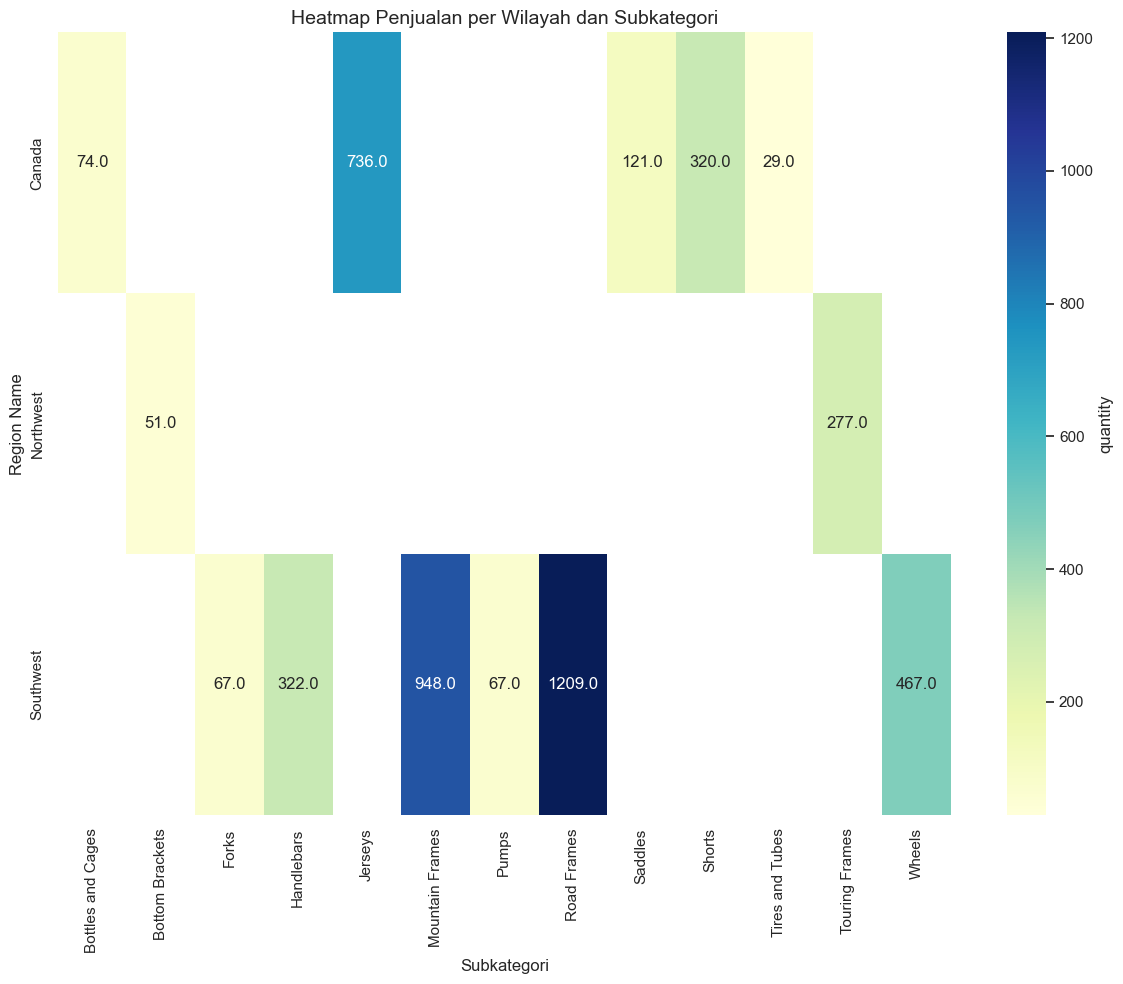

In [ ]:
# Intensitas penjualan berdasarkan wilayah dan subkategori
region_subcat = top_regions_per_subcategory.pivot_table(values="quantity", index="region_name", columns="subcategory", aggfunc="sum")
plt.figure(figsize=(12, 10))
sns.heatmap(region_subcat, annot=True, fmt=".1f", cmap="YlGnBu", cbar_kws={"label": "quantity"})
plt.title("Heatmap Penjualan per Wilayah dan Subkategori", fontsize=14)
plt.ylabel("Region Name", fontsize=12)
plt.xlabel("Subkategori", fontsize=12)
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error


In [52]:
# Konversi order_date ke datetime
top_regions_per_subcategory["order_date"] = pd.to_datetime(top_regions_per_subcategory["order_date"])

# Buat fitur tambahan
top_regions_per_subcategory["year"] = top_regions_per_subcategory["order_date"].dt.year
top_regions_per_subcategory["month"] = top_regions_per_subcategory["order_date"].dt.month
top_regions_per_subcategory["quarter"] = top_regions_per_subcategory["order_date"].dt.quarter

# Fitur yang relevan
features = ["year", "month", "quarter"]
target = "quantity"

In [53]:
# Split data
X = top_regions_per_subcategory[features]
y = top_regions_per_subcategory[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [54]:
# Inisialisasi model
model = RandomForestRegressor(random_state=42, n_estimators=100)

# Latih model
model.fit(X_train, y_train)

# Prediksi
y_pred = model.predict(X_test)


In [55]:
# Evaluasi model
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"Mean Absolute Error: {mae}")
print(f"Root Mean Squared Error: {rmse}")


Mean Absolute Error: 5.405833333333334
Root Mean Squared Error: 6.47826640262141


In [56]:
# Membuat tabel hasil prediksi
result_df = X_test.copy()
result_df["Actual"] = y_test.values
result_df["Predicted"] = y_pred
result_df["Error"] = result_df["Actual"] - result_df["Predicted"]

# Menampilkan hasil dalam tabel
result_df


,year,month,quarter,Actual,Predicted,Error
386,2019,7,3,15,13.2495,1.7505
3186,2020,4,2,3,13.2495,-10.2495
12806,2019,8,3,1,5.2175,-4.2175


In [57]:
top_regions_per_subcategory

,region_name,country,subcategory,order_date,quantity,sales,year,month,quarter
12806,Northwest,United States,Bottles and Cages,2019-08-06,1,65.76,2019,8,3
4489,Northwest,United States,Bottom Brackets,2019-12-11,6,1093.30,2019,12,4
3370,Southwest,United States,Forks,2018-09-14,2,2396.98,2018,9,3
3844,Canada,Canada,Handlebars,2019-09-03,6,1557.52,2019,9,3
2949,Southwest,United States,Jerseys,2019-09-02,12,3609.44,2019,9,3
615,Canada,Canada,Mountain Frames,2019-07-28,16,37780.64,2019,7,3
10584,France,France,Pumps,2018-07-19,1,150.67,2018,7,3
730,Southwest,United States,Road Frames,2018-07-23,17,33683.50,2018,7,3
5558,Northwest,United States,Saddles,2019-08-05,8,666.41,2019,8,3
3186,Northwest,United States,Shorts,2020-04-05,3,2831.45,2020,4,2
